In [1]:
import pandas as pd
from const import Z_PATH
import os
import re
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# get file hash
def get_account_trading_hash(acc:str) -> dict:
    trading_files = os.path.join(Z_PATH, 'tradings')
    co5_trading_path = os.path.join(trading_files, 'co5')
    trading_files = [os.path.join(co5_trading_path, f) for f in os.listdir(co5_trading_path) if f.endswith('_sorted.csv')]
    trading_date = list(map(lambda x: x.split('_')[-2], trading_files))
    trading_hash = dict(zip(trading_date, trading_files))
    return trading_hash

In [3]:
co5_trade_record = get_account_trading_hash('co5')
co5_trade_record

{'230807': 'Z:\\300_Group\\HFT\\Program\\CTA_UI\\tradings\\co5\\trading_230807_sorted.csv',
 '230808': 'Z:\\300_Group\\HFT\\Program\\CTA_UI\\tradings\\co5\\trading_230808_sorted.csv',
 '230809': 'Z:\\300_Group\\HFT\\Program\\CTA_UI\\tradings\\co5\\trading_230809_sorted.csv',
 '230814': 'Z:\\300_Group\\HFT\\Program\\CTA_UI\\tradings\\co5\\trading_230814_sorted.csv',
 '230822': 'Z:\\300_Group\\HFT\\Program\\CTA_UI\\tradings\\co5\\trading_230822_sorted.csv',
 '230824': 'Z:\\300_Group\\HFT\\Program\\CTA_UI\\tradings\\co5\\trading_230824_sorted.csv',
 '230825': 'Z:\\300_Group\\HFT\\Program\\CTA_UI\\tradings\\co5\\trading_230825_sorted.csv',
 '230829': 'Z:\\300_Group\\HFT\\Program\\CTA_UI\\tradings\\co5\\trading_230829_sorted.csv',
 '230830': 'Z:\\300_Group\\HFT\\Program\\CTA_UI\\tradings\\co5\\trading_230830_sorted.csv',
 '230901': 'Z:\\300_Group\\HFT\\Program\\CTA_UI\\tradings\\co5\\trading_230901_sorted.csv',
 '230904': 'Z:\\300_Group\\HFT\\Program\\CTA_UI\\tradings\\co5\\trading_230904_s

In [4]:
def extract_all_breed_trading(trading_hash:dict, breed:str) -> pd.DataFrame:
    trading_data = pd.DataFrame()
    for date, trading_file in trading_hash.items():
        trading = pd.read_csv(trading_file, encoding="GBK")
        trading['date'] = date
        trading['breed'] = trading['套利对'].apply(lambda x: re.findall(r'[a-zA-Z]+', x)[0])
        trading = trading[trading['breed'] == breed]
        trading_data = pd.concat([trading_data, trading])
    trading_data = trading_data.sort_values(by=['交易时间'])
    return trading_data

In [5]:
def calculate_trade_vol(near:str, forward:str, oper:str, num:int) -> int:
    if int(near) < int(forward):
        if oper == '买':
            return num
        else:
            return -1 * num
    else:
        if oper == '买':
            return -1 * num
        else:
            return num

In [6]:
def parse_single_breed_trans_record(breed_trans_record:pd.DataFrame) -> pd.DataFrame:
    breed_trans_record['near'] = breed_trans_record['套利对'].apply(lambda x: re.findall(r'[0-9]+', x.split('-')[0])[0])
    breed_trans_record['forward'] = breed_trans_record['套利对'].apply(lambda x: re.findall(r'[0-9]+', x.split('-')[1])[0])
    breed_trans_record['trade_vol'] = breed_trans_record.apply(lambda x: calculate_trade_vol(x['near'], x['forward'], x['操作'], x['手数']), axis=1)
    breed_trans_record['net_pos'] = breed_trans_record['trade_vol'].cumsum()
    return breed_trans_record
    

In [7]:
sc_df = extract_all_breed_trading(co5_trade_record, 'SC')
sc_df = parse_single_breed_trans_record(sc_df)

In [8]:
sc_df

,套利对,交易时间,操作,价格,手数,date,breed,near,forward,trade_vol,net_pos
91,SC2304-2305,2023-02-17 14:50:33,买,4.00,4,230217,SC,2304,2305,4,4
7,SC2304-2305,2023-02-20 21:06:25,卖,2.55,2,230220,SC,2304,2305,-2,2
8,SC2304-2305,2023-02-20 21:06:28,卖,2.60,2,230220,SC,2304,2305,-2,0
38,SC2304-2305,2023-02-21 10:33:43,买,0.10,1,230221,SC,2304,2305,1,1
39,SC2304-2305,2023-02-21 10:33:57,买,0.10,3,230221,SC,2304,2305,3,4
...,...,...,...,...,...,...,...,...,...,...,...
8,SC2408-2409,2024-06-04 13:30:12,卖,0.90,1,240604,SC,2408,2409,-1,7
7,SC2408-2409,2024-06-04 22:31:54,买,0.30,1,240604,SC,2408,2409,1,8
6,SC2407-2408,2024-06-05 11:06:39,卖,0.90,1,240605,SC,2407,2408,-1,7
8,SC2408-2409,2024-06-05 11:17:20,卖,0.85,2,240605,SC,2408,2409,-2,5


C:\Users\Han.Hao\AppData\Local\Temp\ipykernel_27012\3922286541.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')


Text(0.5, 0, 'trading_time')

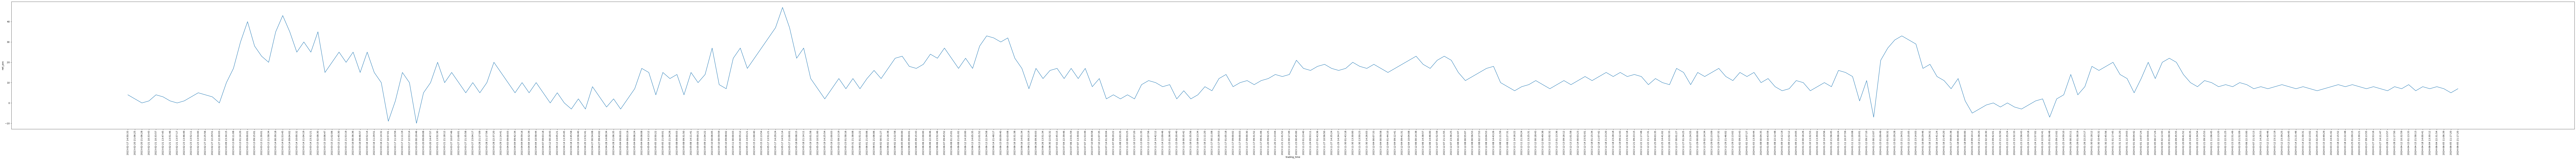

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(200, 10)
sns.lineplot(x=sc_df['交易时间'], y=sc_df['net_pos'], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
ax.set_xlabel('trading_time')

In [10]:
def annotate_trade_oper(trade_df:pd.DataFrame) -> pd.DataFrame:
    net_pos = 0
    for idx, row in trade_df.iterrows():
        # 查验交易时间
        # 交易时段内
        net_pos_intention_after = row['net_pos']
        if net_pos == 0 and net_pos_intention_after > 0:
            flag = "买开"
        elif net_pos == 0 and net_pos_intention_after < 0:
            flag = "卖开"
        elif net_pos > 0 and net_pos_intention_after >= 0 and row['trade_vol'] < 0:
            flag = "卖平"
        elif net_pos < 0 and net_pos_intention_after <= 0 and row['trade_vol'] > 0:
            flag = "买平"
        elif net_pos > 0 and row['trade_vol'] > 0:
            flag = "买追"
        elif net_pos < 0 and row['trade_vol'] < 0:
            flag = "卖追"
        elif net_pos < 0 and net_pos_intention_after > 0:
            flag = "买平买开"
        elif net_pos > 0 and net_pos_intention_after < 0:
            flag = "卖平卖开"
        net_pos = net_pos_intention_after
        trade_df.loc[idx, 'OPERFLAG'] = flag
    return trade_df

In [12]:
annotated_sc = annotate_trade_oper(sc_df)

In [15]:
annotated_sc[(annotated_sc['OPERFLAG'] == "买平") | (annotated_sc['OPERFLAG'] == "卖平")]

,套利对,交易时间,操作,价格,手数,date,breed,near,forward,trade_vol,net_pos,OPERFLAG
8,SC2304-2305,2023-02-20 21:06:28,卖,2.600000,2,230220,SC,2304,2305,-2,0,卖平
40,SC2304-2305,2023-02-21 13:47:45,卖,0.400000,1,230221,SC,2304,2305,-1,3,卖平
41,SC2304-2305,2023-02-21 13:51:46,卖,0.400000,2,230221,SC,2304,2305,-2,1,卖平
42,SC2304-2305,2023-02-21 13:57:17,卖,0.500000,1,230221,SC,2304,2305,-1,0,卖平
2,SC2304-2305,2023-02-23 13:52:11,买,-1.400000,2,230223,SC,2304,2305,2,3,卖平
...,...,...,...,...,...,...,...,...,...,...,...,...
10,SC2405-2406,2024-04-12 10:32:59,卖,3.700000,1,240412,SC,2405,2406,-1,7,卖平
6,SC2405-2406,2024-04-15 21:58:13,卖,1.933333,3,240415,SC,2405,2406,-3,6,卖平
8,SC2408-2409,2024-06-04 13:30:12,卖,0.900000,1,240604,SC,2408,2409,-1,7,卖平
6,SC2407-2408,2024-06-05 11:06:39,卖,0.900000,1,240605,SC,2407,2408,-1,7,卖平


In [ ]:
def calculate_profit(day_record:pd.DataFrame):
    net_value = 0
    avg_price = 0
    open_time = 0
    open_counter = 0
    for idx, row in day_record.iterrows():
        if row['OPER_FLAG'] == "买开":
            day_record.loc[idx, 'SINGLE_PROFIT'] = 0
            net_value = -1 * row['MATCH_AMT']
            avg_price = row['MATCH_PRICE']
            day_record.loc[idx, 'HOLDING_PRICE'] = avg_price
            open_time = row['TIME_STAMP']
            day_record.loc[idx, 'HOLDING_PERIOD'] = 0
            open_counter = 1

        elif row['OPER_FLAG'] == "卖开":
            day_record.loc[idx, 'SINGLE_PROFIT'] = 0
            net_value = row['MATCH_AMT']
            avg_price = row['MATCH_PRICE']
            day_record.loc[idx, 'HOLDING_PRICE'] = avg_price
            open_time = row['TIME_STAMP']
            day_record.loc[idx, 'HOLDING_PERIOD'] = 0
            open_counter = 1

        elif row['OPER_FLAG'] == "卖平" or row['OPER_FLAG'] == "强制卖平":
            day_record.loc[idx, 'SINGLE_PROFIT'] = (row['MATCH_PRICE'] - avg_price) * row['MATCH_QTY']
            net_value = -1 * avg_price * row['NET_POS']
            day_record.loc[idx, 'HOLDING_PRICE'] = avg_price
            holding_duration = (row['TIME_STAMP'] - open_time).total_seconds()
            day_record.loc[idx, 'HOLDING_PERIOD'] = holding_duration

        elif row['OPER_FLAG'] == "买平" or row['OPER_FLAG'] == "强制买平":
            day_record.loc[idx, 'SINGLE_PROFIT'] = (-1 * row['MATCH_PRICE'] + avg_price) * row['MATCH_QTY']
            net_value = -1 * avg_price * row['NET_POS']
            day_record.loc[idx, 'HOLDING_PRICE'] = avg_price
            holding_duration = (row['TIME_STAMP'] - open_time).total_seconds()
            day_record.loc[idx, 'HOLDING_PERIOD'] = holding_duration

        elif row['OPER_FLAG'] == "买追":
            day_record.loc[idx, 'SINGLE_PROFIT'] = 0
            net_value -= row['MATCH_AMT']
            avg_price = -1 * net_value / row['NET_POS']
            day_record.loc[idx, 'HOLDING_PRICE'] = avg_price
            open_counter += 1
            open_time = open_time + (row['TIME_STAMP'] - open_time) / 2
            day_record.loc[idx, 'HOLDING_PERIOD'] = 0

        elif row['OPER_FLAG'] == "卖追":
            day_record.loc[idx, 'SINGLE_PROFIT'] = 0
            net_value += row['MATCH_AMT']
            avg_price = -1 * net_value / row['NET_POS']
            day_record.loc[idx, 'HOLDING_PRICE'] = avg_price
            open_counter += 1
            open_time = open_time + (row['TIME_STAMP'] - open_time) / 2
            day_record.loc[idx, 'HOLDING_PERIOD'] = 0

        elif row['OPER_FLAG'] == "买平买开":
            # 先买平
            day_record.loc[idx, 'SINGLE_PROFIT'] = (-1 * row['MATCH_PRICE'] + avg_price) * abs(row['CHANGE_QTY'] - row['NET_POS'])
            holding_duration = (row['TIME_STAMP'] - open_time).total_seconds()
            day_record.loc[idx, 'HOLDING_PERIOD'] = holding_duration
            # 再买开
            net_value = -1 * row['MATCH_PRICE'] * row['NET_POS']
            avg_price = row['MATCH_PRICE']
            day_record.loc[idx, 'HOLDING_PRICE'] = avg_price
            open_time = row['TIME_STAMP']
            open_counter = 1

        elif row['OPER_FLAG'] == "卖平卖开":
            # 先卖平
            day_record.loc[idx, 'SINGLE_PROFIT'] = (row['MATCH_PRICE'] - avg_price) * abs(row['CHANGE_QTY'] - row['NET_POS'])
            holding_duration = (row['TIME_STAMP'] - open_time).total_seconds()
            day_record.loc[idx, 'HOLDING_PERIOD'] = holding_duration
            # 再卖开
            net_value = -1 * row['MATCH_PRICE'] * row['NET_POS']
            avg_price = row['MATCH_PRICE']
            day_record.loc[idx, 'HOLDING_PRICE'] = avg_price
            open_time = row['TIME_STAMP']
            open_counter = 1
    test_df = day_record